### Init

In [10]:
!pip install imbalanced-learn

In [11]:
!pip install plotly

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import seaborn as sns

In [13]:
%matplotlib inline
import plotly.io as pio
pio.renderers.default = 'iframe'

### Get and format data

In [14]:
df_raw = pd.read_csv("heart.csv")

df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [15]:
df = df_raw.copy()
df = df.rename(columns={"Residence_type": "residence_type"})


df = df.drop(columns=['id'], axis=1)

# Male = 0, Female = 1
df['gender'] = np.where(df['gender'] == 'Male', 0, 1)

# Yes = 0, No = 1
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 0, 1)

# Urban = 0, Rural = 1
df['residence_type'] = np.where(df['residence_type'] == 'Urban', 0, 1)

# LabelEncoder
# work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
# smoking_status ['never smoked' 'formerly smoked' 'Unknown' 'smokes']
le = LabelEncoder()
df['work_type'] = le.fit_transform(df['work_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,28.0,0,0,0,2,0,79.53,31.1,2,0
1,0,33.0,0,0,0,2,1,78.44,23.9,1,0
2,1,42.0,0,0,0,2,1,103.00,40.3,0,0
3,0,56.0,0,0,0,2,0,64.87,28.8,2,0
4,1,24.0,0,0,1,2,1,73.36,28.8,2,0


### Get train and test

In [16]:
data = df.drop(columns=['stroke'], axis=1)
target = df[['stroke']]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

In [18]:
sm = SMOTE(random_state=1)
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)

### Processing

#### Checking post prunning

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

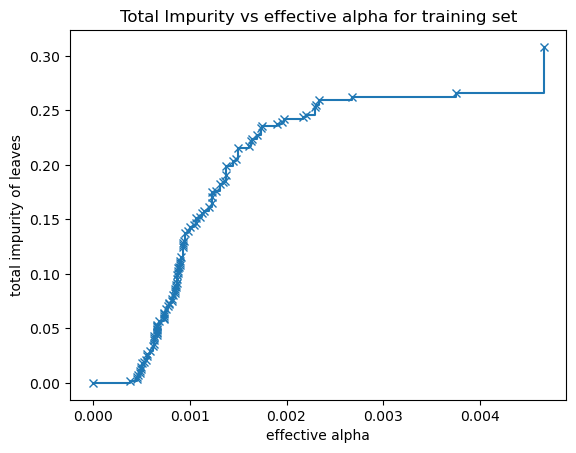

In [19]:
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_features='sqrt')
scaler = StandardScaler()
x_train_prun = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
x_test_prun = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

path = dt.cost_complexity_pruning_path(x_train_prun, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="x", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [20]:
clfs = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_features='sqrt', ccp_alpha=ccp_alpha)
    dt.fit(x_train_prun, y_train)
    clfs.append(dt)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.063911283915401


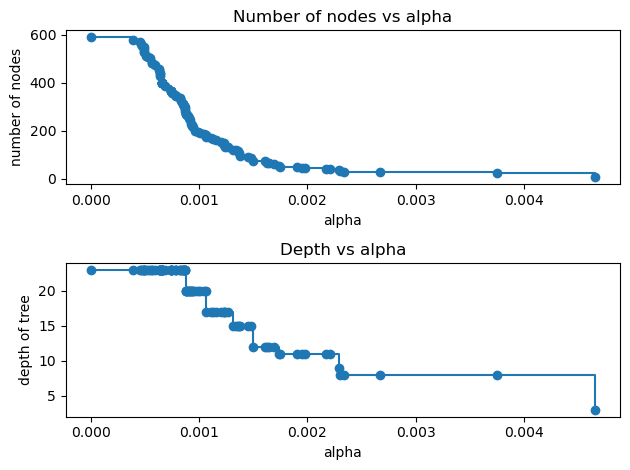

In [21]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

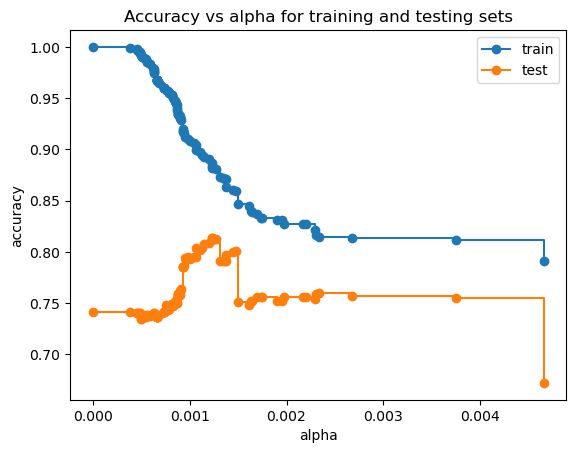

In [22]:
train_scores = [clf.score(x_train_prun, y_train) for clf in clfs]
test_scores = [clf.score(x_test_prun, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

#### Training

In [23]:
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_features='sqrt')
scaler = StandardScaler()

In [24]:
pipe = Pipeline(steps=[("scaler", scaler), ("dt", dt)])

param_grid = {
    'dt__max_depth': list(range(1, 11, 1)),
    'dt__min_samples_leaf': [1, 2, 3],
    'dt__max_leaf_nodes': [None, 5, 10],
}

grid_dt = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_dt.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               max_features='sqrt',
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'dt__max_leaf_nodes': [None, 5, 10],
                         'dt__min_samples_leaf': [1, 2, 3]},
             scoring='recall')

In [25]:
print(f"Melhores parâmetros KNN: {grid_dt.best_params_}")

Melhores parâmetros KNN: {'dt__max_depth': 5, 'dt__max_leaf_nodes': None, 'dt__min_samples_leaf': 2}


### Testing

In [26]:
grid_dt.score(x_test, y_test)

0.912

In [27]:
y_pred = grid_dt.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.80      2936
           1       0.10      0.91      0.19       125

    accuracy                           0.67      3061
   macro avg       0.55      0.79      0.49      3061
weighted avg       0.96      0.67      0.77      3061



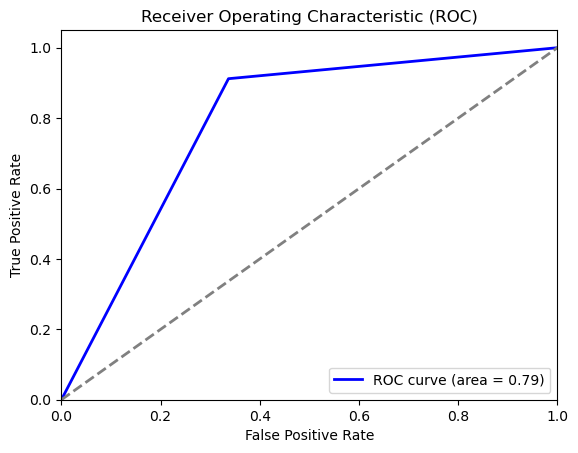

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

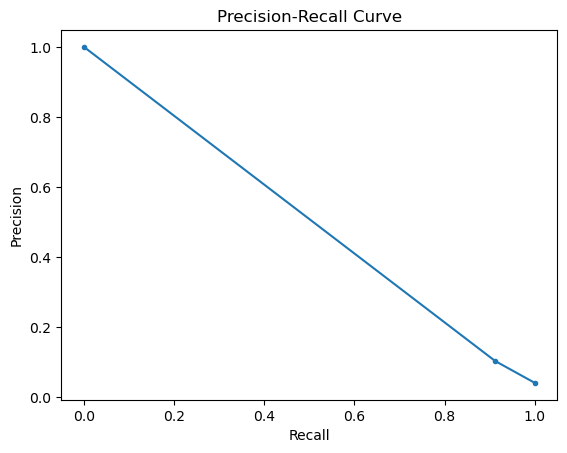

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

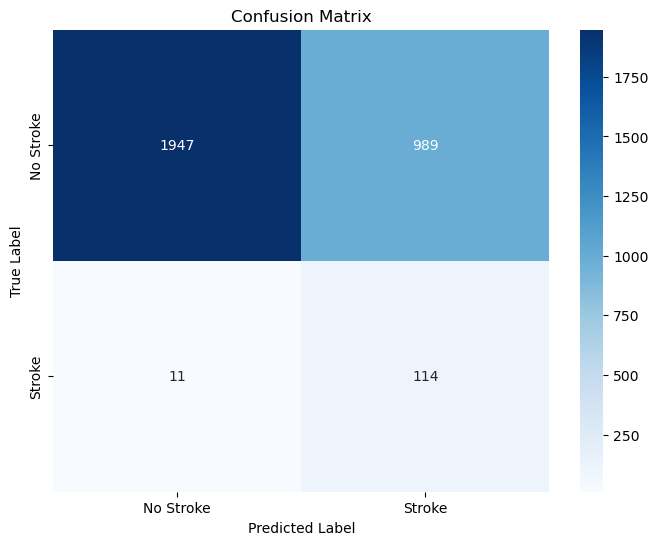

In [30]:
cm = confusion_matrix(y_test, y_pred)

# Define the labels
labels = ['No Stroke', 'Stroke']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()